In [497]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import time
import data_manipulator
import create_model
import data_reader
import finance_calculator
import latex
from matplotlib.ticker import MaxNLocator

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.titlesize"] = 22
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu

#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

In [498]:
# load back history data
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
ASSET_TO_PREDICT = 'ty1'                  #--- VAR CHANGE
with open('models/last_run_model_name.txt') as f:
    last_model_name = f.readline()
    print(last_model_name)
model_name = last_model_name                 #--- VAR CHANGE
model_load = keras.models.load_model(f'models/{model_name}.hdf5')
history_load = np.load(f'history/{model_name}.npy',allow_pickle='TRUE').item()

01.24.1815-ty1-60-1-gru-sigmoid


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


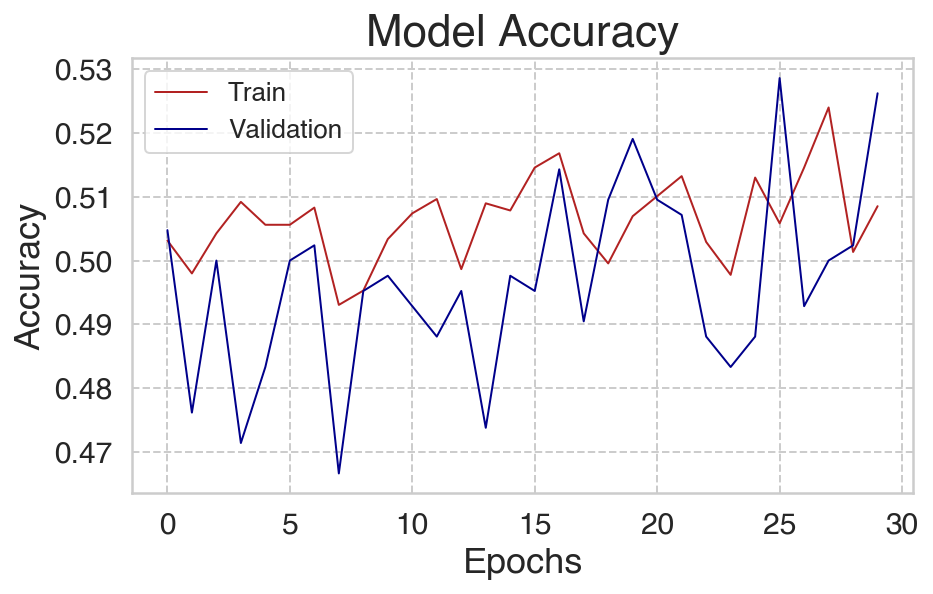

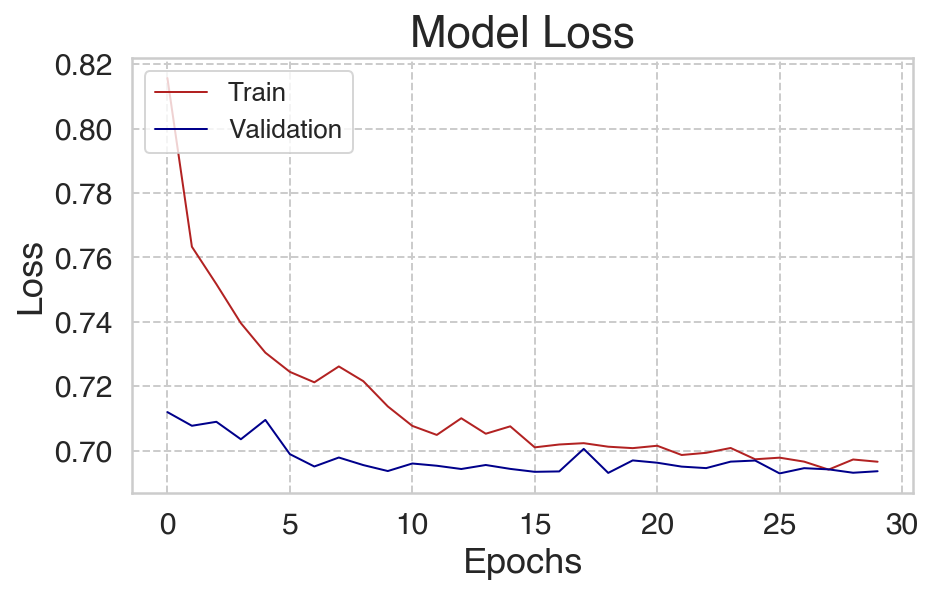

In [499]:
fig1, axs1 = utils.plot_history_data_accuracy(history_load)
plt.tick_params(axis='both', which='major', labelsize=15)
save_loc = f'plots/{last_model_name}_model_accuracy.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")

fig2, axs2 = utils.plot_history_data_loss(history_load)
plt.tick_params(axis='both', which='major', labelsize=15)
save_loc = f'plots/{last_model_name}_model_loss.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")

In [500]:
# CREDIT DATA
credit_df = pd.DataFrame() # begin empty
rx1, ty1, ik1, oe1, du1 = data_reader.credit()
# credit_df['rx1'] = rx1['RX1 Comdty']             # --VAR CHANGE 
credit_df['ty1'] = ty1['TY1 Comdty']
# credit_df['ik1'] = ik1['IK1 Comdty']
# credit_df['oe1'] = oe1['OE1 Comdty']
# credit_df['du1'] = du1['DU1 Comdty']

# CRYPTO DATA
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]
crypto_df = data_reader.crypto(ratios)

# set dataset                              
dataset_df = credit_df                      # --VAR CHANGE 

val_df = data_manipulator.splitter(dataset_df, cutoff=0.10)[1]

df_rp = utils.getReturnAndPred_sigmoidModel(val_df, SEQ_LEN+1, ASSET_TO_PREDICT, model_load)

[0.50373816]
[0.522889]
[0.49423832]
[0.49336606]
[0.4803989]
[0.5091633]
[0.51780826]
[0.5074107]
[0.4978824]
[0.50453806]
[0.51228744]
[0.5206091]
[0.52652794]
[0.5002505]
[0.5080289]
[0.50219417]
[0.50587]
[0.50749654]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


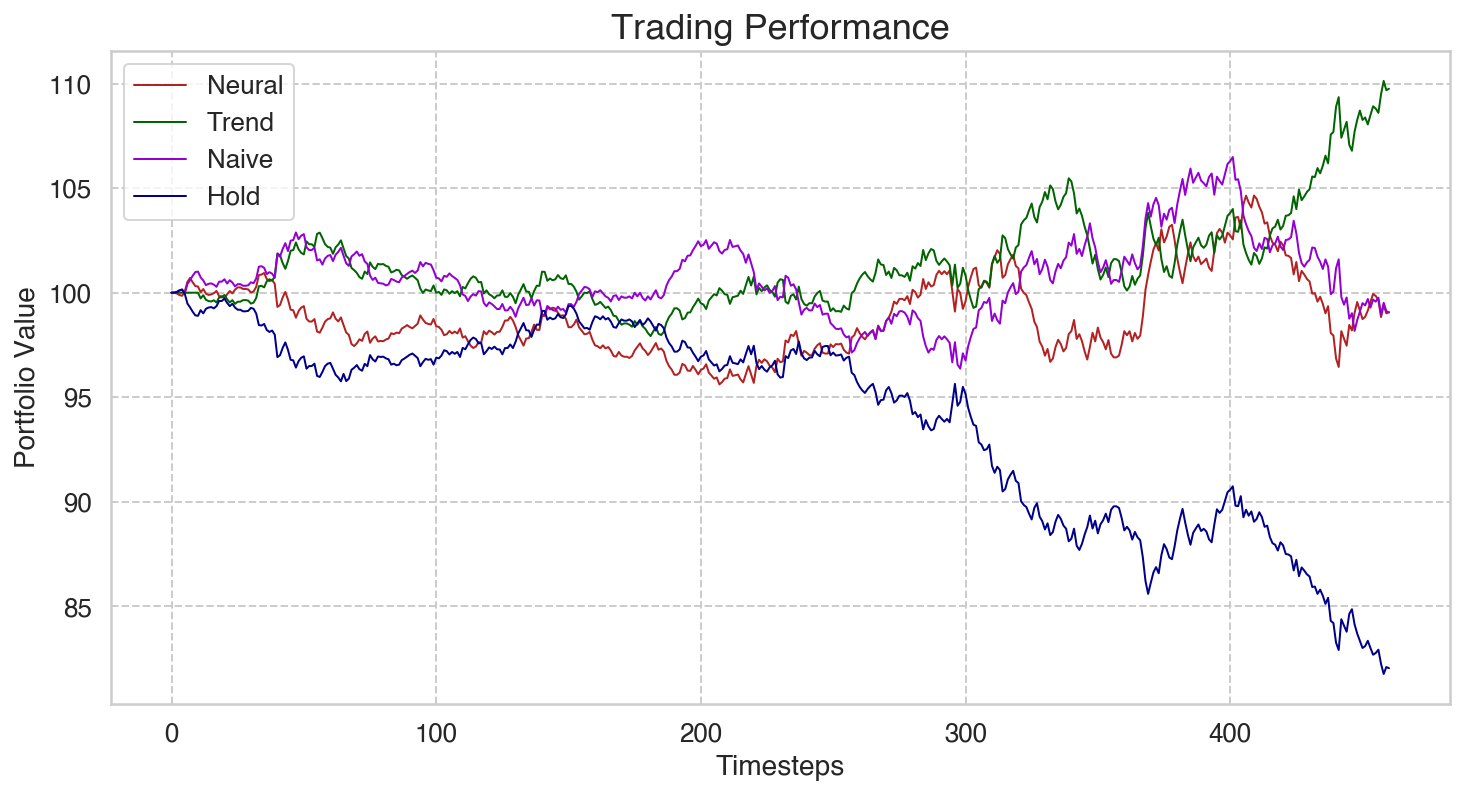

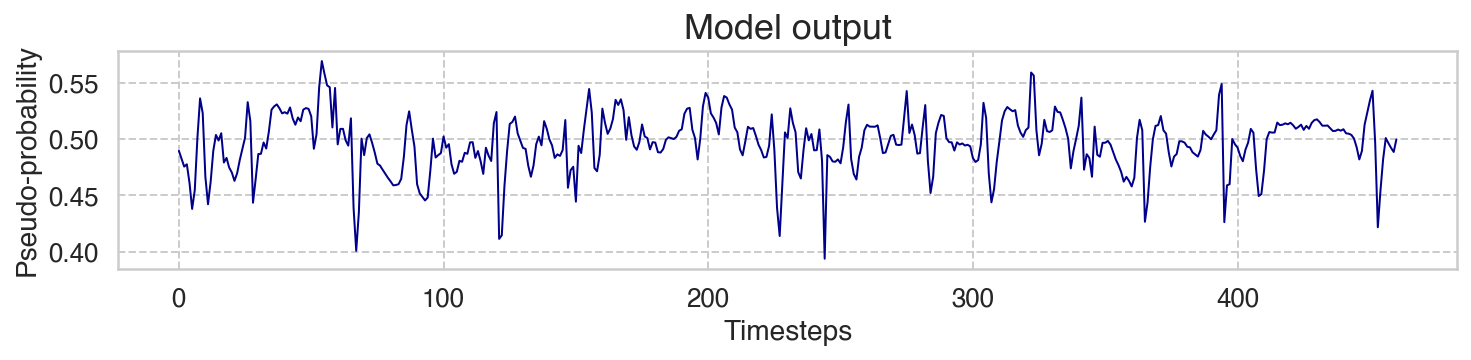

In [501]:
# n = 0                       #--- VAR CHANGE
# first_n_predictions = df_rp.loc[0:n, 'probability_up']
# mean = np.mean(first_n_predictions)
# print(f'Mean of {n} first predictions', mean)

treshhold = 0.5           # 1 = always short, 0 = always long. mean ~ 50/50 short/long
copy_df = df_rp[0:].reset_index(drop=True)          #if treshhold calculated above, 0 must change to n here!

# Portfolio values
portfolio_value_neural = finance_calculator.portfolio_value_neural(copy_df, treshhold)
nbr_previous_days = 10
portfolio_value_trend = finance_calculator.portfolio_value_trend(copy_df, nbr_previous_days)
portfolio_value_naive = finance_calculator.portfolio_value_naive(copy_df)
portfolio_value_hold = finance_calculator.portfolio_value_hold(copy_df)

# Plots
fig1, axs1 = plt.subplots(1,1, figsize=(12,6))
plt.tick_params(axis='both', which='major', labelsize=13)
fig1 = plt.plot(portfolio_value_neural, color='firebrick', linestyle='-', linewidth='1')
fig1 = plt.plot(portfolio_value_trend, color='darkgreen', linestyle='-', linewidth='1')
fig1 = plt.plot(portfolio_value_naive, color='darkviolet', linestyle='-', linewidth='1')
fig1 = plt.plot(portfolio_value_hold, color='darkblue', linestyle='-', linewidth='1')
axs1.yaxis.set_major_locator(MaxNLocator(7)) 
axs1 = plt.title('Trading Performance', size=18)
axs1 = plt.ylabel('Portfolio Value', size=14)
axs1 = plt.xlabel('Timesteps', size=14)
axs1 = plt.legend(['Neural', 'Trend', 'Naive', 'Hold'], loc='upper left')
save_loc = f'plots/{last_model_name}_trading_performance.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")

# Model output
fig2, axs2 = plt.subplots(1,1, figsize=(12,2))
plt.tick_params(axis='both', which='major', labelsize=13)
axs2.yaxis.set_major_locator(MaxNLocator(4)) 
fig2 = plt.plot(copy_df['probability_up'], color='darkblue', linewidth='1')
axs2 = plt.title('Model output', size=18)
axs2 = plt.ylabel('Pseudo-probability', size=14)
axs2 = plt.xlabel('Timesteps', size=14)
save_loc = f'plots/{last_model_name}_model_output.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")


In [502]:
# Financial Metrics
one_year_of_returns = 365 #number of datapoints that equals one year of return data in portfolio value

print('NEURAL')
returns_neural = finance_calculator.returns(portfolio_value_neural)
sharpe_neural = finance_calculator.sharpe_ratio(returns_neural, one_year_of_returns, 0.02)
sortino_neural = finance_calculator.sortino_ratio(returns_neural, one_year_of_returns, 0.02)
print("Sharpe-ratio: {:5.2f}".format(sharpe_neural))
print("Sortino-ratio: {:5.2f}".format(sortino_neural))
gross_return_neural = finance_calculator.gross_return(portfolio_value_neural)
print("Gross return: {:5.2f}%".format(100 * gross_return_neural))
maximal_drawdown_neural = finance_calculator.maximal_drawdown(portfolio_value_neural)
print("Maximal Drawdown: {:5.2f}%".format(100 * maximal_drawdown_neural))

print('')
print('TREND')
returns_trend = finance_calculator.returns(portfolio_value_trend)
sharpe_trend = finance_calculator.sharpe_ratio(returns_trend, one_year_of_returns, 0.02)
sortino_trend = finance_calculator.sortino_ratio(returns_trend, one_year_of_returns, 0.02)
print("Sharpe-ratio: {:5.2f}".format(sharpe_trend))
print("Sortino-ratio: {:5.2f}".format(sortino_trend))
gross_return_trend = finance_calculator.gross_return(portfolio_value_trend)
print("Gross return: {:5.2f}%".format(100 * gross_return_trend))
maximal_drawdown_trend = finance_calculator.maximal_drawdown(portfolio_value_trend)
print("Maximal Drawdown: {:5.2f}%".format(100 * maximal_drawdown_trend))

print('')
print('NAIVE')
returns_naive = finance_calculator.returns(portfolio_value_naive)
sharpe_naive = finance_calculator.sharpe_ratio(returns_naive, one_year_of_returns, 0.02)
sortino_naive = finance_calculator.sortino_ratio(returns_naive, one_year_of_returns, 0.02)
print("Sharpe-ratio: {:5.2f}".format(sharpe_naive))
print("Sortino-ratio: {:5.2f}".format(sortino_naive))
gross_return_naive = finance_calculator.gross_return(portfolio_value_naive)
print("Gross return: {:5.2f}%".format(100 * gross_return_naive))
maximal_drawdown_naive = finance_calculator.maximal_drawdown(portfolio_value_naive)
print("Maximal Drawdown: {:5.2f}%".format(100 * maximal_drawdown_naive))


print('')
print('HOLD')
returns_hold = finance_calculator.returns(portfolio_value_hold)
sharpe_hold = finance_calculator.sharpe_ratio(returns_hold, one_year_of_returns, 0.02)
sortino_hold = finance_calculator.sortino_ratio(returns_hold, one_year_of_returns, 0.02)
print("Sharpe-ratio: {:5.2f}".format(sharpe_hold))
print("Sortino-ratio: {:5.2f}".format(sortino_hold))
gross_return_hold = finance_calculator.gross_return(portfolio_value_hold)
print("Gross return: {:5.2f}%".format(100 * gross_return_hold))
maximal_drawdown_hold = finance_calculator.maximal_drawdown(portfolio_value_hold)
print("Maximal Drawdown: {:5.2f}%".format(100 * maximal_drawdown_hold))



NEURAL
Sharpe-ratio: -0.33
Sortino-ratio: -0.54
Gross return: -0.93%
Maximal Drawdown: -7.83%

TREND
Sharpe-ratio:  0.76
Sortino-ratio:  1.17
Gross return:  9.75%
Maximal Drawdown: -5.09%

NAIVE
Sharpe-ratio: -0.33
Sortino-ratio: -0.47
Gross return: -0.95%
Maximal Drawdown: -7.81%

HOLD
Sharpe-ratio: -2.35
Sortino-ratio: -3.39
Gross return: -17.95%
Maximal Drawdown: -18.35%


In [503]:
# Statistics
finance_calculator.confusion_stats_neural(copy_df, treshhold)
correlation = np.corrcoef(portfolio_value_neural, portfolio_value_hold)[1][0]
print("Correlation: {:5.2f}%".format(100 * correlation))

finance_calculator.confusion_stats_trend(copy_df, nbr_previous_days)
correlation = np.corrcoef(portfolio_value_trend, portfolio_value_hold)[1][0]
print("Correlation: {:5.2f}%".format(100 * correlation))

finance_calculator.confusion_stats_naive(copy_df)
correlation = np.corrcoef(portfolio_value_naive, portfolio_value_hold)[1][0]
print("Correlation: {:5.2f}%".format(100 * correlation))



NEURAL STATS:
TP: 100
FP: 121
TN: 120
FN: 120
Accuracy: 47.72%

TPR: 45.45%
TNR: 49.79%
PPV: 45.25%
NPV: 50.00%

Correlation: -38.82%

TREND STATS:
TP: 73
FP: 86
TN: 149
FN: 143
Accuracy: 49.22%

TPR: 33.80%
TNR: 63.40%
PPV: 45.91%
NPV: 51.03%

Correlation: -83.98%

NAIVE STATS:
TP: 107
FP: 112
TN: 129
FN: 112
Accuracy: 51.30%

TPR: 48.86%
TNR: 53.53%
PPV: 48.86%
NPV: 53.53%

Correlation: -34.58%


In [504]:
## PLACEHOLDER
portfolio_volatility_yearly_neural = finance_calculator.portfolio_yearly_standard_deviation(portfolio_value_neural)
print("Yearly Portfolio Volatility Neural: {:5.2f}%".format(100 * portfolio_volatility_yearly_neural))

portfolio_volatility_yearly_trend = finance_calculator.portfolio_yearly_standard_deviation(portfolio_value_trend)
print("Yearly Portfolio Volatility Trend: {:5.2f}%".format(100 * portfolio_volatility_yearly_trend))

portfolio_volatility_yearly_naive = finance_calculator.portfolio_yearly_standard_deviation(portfolio_value_naive)
print("Yearly Portfolio Volatility Naive: {:5.2f}%".format(100 * portfolio_volatility_yearly_naive))

portfolio_volatility_yearly_hold = finance_calculator.portfolio_yearly_standard_deviation(portfolio_value_hold)
print("Yearly Portfolio Volatility Hold: {:5.2f}%".format(100 * portfolio_volatility_yearly_hold))


#change to new improved sharpes ?
print("Sharpe-ratio: {:5.2f}".format(sharpe_trend))
sharpe_ratio2 = finance_calculator.sharpe_ratio2(portfolio_value_trend, 0.02)
print("sharpe-ratio2: {:5.2f}".format(sharpe_ratio2))



Yearly Portfolio Volatility Neural:  6.59%
Yearly Portfolio Volatility Trend:  6.36%
Yearly Portfolio Volatility Naive:  6.09%
Yearly Portfolio Volatility Hold:  6.35%
Sharpe-ratio:  0.76
sharpe-ratio2:  0.65
